In [5]:
import tensorflow as tf
import numpy as np
import csv
import os
import sys
import time
sys.path.append("../")
from net import *
from data_read import *
from data_read import *
from evaluation import *

import argparse


import time




parser = argparse.ArgumentParser()



parser.add_argument('--dataset_name', action="store", dest= "dataset_name",default="NYU",help='KITTI, NYU')


parser.add_argument('--model_name', action="store", dest= "model_name",default="ResNet18_NO_BN_l2_cross_domain",help='ResNet18_NO_BN_l2,ResNet18_NO_BN_l2_light,ResNet18_NO_BN_l2_light_light,ResNet18_NO_BN_l2_image,ResNet18_NO_BN_l2_light_image,Sparsity')


parser.add_argument('--epoch_eval', action="store", dest="epoch_eval", type=int, default=15,help='eval from which epoch')


parser.add_argument('--table_size', action="store", dest="table_size", type=int, default=7,help='the size of look up table')

parser.add_argument('--scale_range', action="store", dest="scale_range", type=int, default=10.0,help='scale range')

parser.add_argument('--scale_num', action="store", dest="scale_num", type=int, default=4,help='scale num')

parser.add_argument('--line_num', action="store", dest="line_num", type=int, default=200,help='how many lidar lines, refer to sample_num for NYU')

parser.add_argument('--correct', action="store", dest="correct", type=bool, default=False,help='if correct outliers')


input_parameters = parser.parse_args([])






save_path='./checkpoints/'+input_parameters.dataset_name+'/'+input_parameters.model_name+'/'+str(input_parameters.line_num)+'/'

save_path=save_path+str(input_parameters.correct)+'/'+str(input_parameters.table_size)+'/'+str(input_parameters.scale_num)+'/'




In [6]:
def nearest_point(refined_lidar):   
    value_mask=np.asarray(1.0-np.squeeze(refined_lidar)>0.1).astype(np.uint8)
    dt,lbl = cv2.distanceTransformWithLabels(value_mask, cv2.DIST_L1, 5, labelType=cv2.DIST_LABEL_PIXEL)
    return dt,lbl


def Distance_Transform(lidar):
    # a,b,c are sparser than lidar
    lidar=np.squeeze(lidar)
    height,width=np.shape(lidar)
    with_value=lidar>0.1
    dt,lbl=nearest_point(lidar)
    depth_list=np.squeeze(lidar[with_value])
    
    label_list=np.reshape(lbl,[1,height*width])
    depth_list_all=depth_list[label_list-1]
   
    depth_map=np.reshape(depth_list_all,(height,width))
    
    return depth_map

In [9]:

input_parameters.dataset_name="NYU"
input_parameters.scale_range=10.0
input_parameters.line_num=200



if input_parameters.dataset_name=='NYU':

    evaluate=Result_NYU() 


    
    
input_parameters.dataset_name="KITTI"
input_parameters.scale_range=90.0
input_parameters.line_num=64

if input_parameters.dataset_name=='KITTI':
    evaluate=Result()

    
    



if input_parameters.model_name=='Sparsity':
    depth_network=SparsityCNN(table_size=input_parameters.table_size,if_correct=input_parameters.correct,scale_range=input_parameters.scale_range,scale_num=input_parameters.scale_num)



if input_parameters.model_name=='ResNet18_NO_BN_l2':
    depth_network=ResNet18_NO_BN_l2(table_size=input_parameters.table_size,if_correct=input_parameters.correct,scale_range=input_parameters.scale_range,scale_num=input_parameters.scale_num)


if input_parameters.model_name=='ResNet18_NO_BN_l2_light':
    depth_network=ResNet18_NO_BN_l2_light(table_size=input_parameters.table_size,if_correct=input_parameters.correct,scale_range=input_parameters.scale_range,scale_num=input_parameters.scale_num)

if input_parameters.model_name=='ResNet18_NO_BN_l2_light_light':
    depth_network=ResNet18_NO_BN_l2_light_light(table_size=input_parameters.table_size,if_correct=input_parameters.correct,scale_range=input_parameters.scale_range,scale_num=input_parameters.scale_num)

if input_parameters.model_name=='ResNet18_NO_BN_l2_cross_domain':
    depth_network=ResNet18_NO_BN_l2_cross_domain(table_size=input_parameters.table_size,if_correct=input_parameters.correct,scale_range=input_parameters.scale_range,scale_num=input_parameters.scale_num)


if input_parameters.model_name=='ResNet18_NO_BN_l2_image':
    depth_network=ResNet18_NO_BN_l2_image(table_size=input_parameters.table_size,if_correct=input_parameters.correct,scale_range=input_parameters.scale_range,scale_num=input_parameters.scale_num)

if input_parameters.model_name=='ResNet18_NO_BN_l2_light_image':
    depth_network=ResNet18_NO_BN_l2_light_image(table_size=input_parameters.table_size,if_correct=input_parameters.correct,scale_range=input_parameters.scale_range,scale_num=input_parameters.scale_num)





depth_network.load_weights(save_path + 'epoch_'+str(input_parameters.epoch_eval)+"_full")







        
rmse_total=0
mae_total=0
irmse_total=0
imae_total=0
if input_parameters.dataset_name=='NYU':
	delta_1_total=0.0
	delta_2_total=0.0
	delta_3_total=0.0
#validation


time_interval=[]
for i in range(1000):
    print (i)
    

        
        
    if i==654 and input_parameters.dataset_name=='NYU':
    	break

    if input_parameters.dataset_name=='KITTI':
        img_batch,lidar_batch,ground_truth,semantic= read_one_val(i,line_number=input_parameters.line_num)

    if input_parameters.dataset_name=='NYU':
    
        img_batch,lidar_batch,ground_truth=read_one_val_NYU(i,sample_rate=input_parameters.line_num)

    
    lidar_only=lidar_batch
    lidar_batch=np.expand_dims(lidar_batch,axis=-1)



    if input_parameters.dataset_name=='KITTI':
        lidar = lidar_batch[:,96:,:,:]
        gt = ground_truth[:,96:,:]
        rgb=img_batch[:,96:,:,:]/255.0
        rgb=np.asarray(rgb).astype(np.float32)
    if input_parameters.dataset_name=='NYU':
        gt = ground_truth
        lidar = lidar_batch
        rgb=img_batch/255.0
        rgb=np.asarray(rgb).astype(np.float32)



   

   


   
    if "image" in input_parameters.model_name:
        depth_predicted,lidar_correction=depth_network.call(lidar,rgb)      
    else:
        depth_predicted,lidar_correction=depth_network.call(lidar)

        

        





    if input_parameters.dataset_name=='NYU':
    	depth_predicted=np.squeeze(depth_predicted)[6:234,8:312]
    	gt=np.squeeze(gt)[6:234,8:312]
    else:
    	depth_predicted=np.squeeze(tf.nn.relu(depth_predicted-0.9)+0.9)
        
    nn_lidar=Distance_Transform(lidar_batch)
    

   
    evaluate.evaluate(np.squeeze(depth_predicted),np.squeeze(gt))
    irmse, imae, mse, rmse, mae=evaluate.irmse, evaluate.imae, evaluate.mse, evaluate.rmse, evaluate.mae
    if input_parameters.dataset_name=='NYU':
    	delta_1,delta_2,delta_3=evaluate.delta1,evaluate.delta2,evaluate.delta3
    	delta_1_total+=delta_1
    	delta_2_total+=delta_2
    	delta_3_total+=delta_3


    rmse_total+=rmse
    mae_total+=mae
    irmse_total+=irmse
    imae_total+=imae
    print ("rmse:")
    print (rmse_total/(i+1))
    print ("mae:")
    print (mae_total/(1+i))
    print ("irmse:")
    print (irmse_total/(1+i))
    print ("imae:")
    print (imae_total/(1+i))
    print ('method time')
    print (np.sum(time_interval)/len(time_interval))

          

if input_parameters.dataset_name=='NYU':
    print ("rmse:")
    print (rmse_total/654.0)
    print ("mae:")
    print (mae_total/654.0)      
    print ("irmse:")
    print (irmse_total/654.0)      
    print ("imae:")
    print (imae_total/654.0) 
    print (delta_1_total/654.0)
    print (delta_2_total/654.0)
    print (delta_3_total/654.0)
else:

	print ("rmse:")
	print (rmse_total/1000.0)
	print ("mae:")
	print (mae_total/1000.0)      
	print ("irmse:")
	print (irmse_total/1000.0)      
	print ("imae:")
	print (imae_total/1000.0)  


print ('method time')
print (np.sum(time_interval)/len(time_interval))



        
    
    
    


0
rmse:
3665.097545158908
mae:
1306.3811128380291
irmse:
12.945112904411666
imae:
7.710232508215212
method time
nan
1
rmse:
2859.983528967554
mae:
1142.2260897699152
irmse:
12.951945090083449
imae:
6.83863373458295
method time
nan
2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in double_scalars


rmse:
2743.8020507886595
mae:
1112.3731212196437
irmse:
13.760484997109904
imae:
7.271428014956451
method time
nan
3
rmse:
2887.898792030417
mae:
1135.1042302697888
irmse:
12.420223432333986
imae:
6.9259368485991715
method time
nan
4
rmse:
2759.537550929178
mae:
1096.1052361735397
irmse:
12.034957187260652
imae:
6.700502471390811
method time
nan
5
rmse:
2819.7596023625324
mae:
1112.7606155572346
irmse:
12.228283897856867
imae:
6.79522044460682
method time
nan
6
rmse:
2782.3122562955696
mae:
1099.0971976717012
irmse:
11.890228396828439
imae:
6.656926035576348
method time
nan
7
rmse:
2710.914733953148
mae:
1072.8746904018226
irmse:
11.475993703441173
imae:
6.386055600448135
method time
nan
8
rmse:
2626.8984212700675
mae:
1055.733212930921
irmse:
10.7914243990015
imae:
6.1197080809263324
method time
nan
9
rmse:
2713.9343302238485
mae:
1090.0263551149576
irmse:
10.906517939579617
imae:
6.263324651279991
method time
nan
10
rmse:
2655.375896506912
mae:
1078.2166488666633
irmse:
10.6942701938

rmse:
2658.141683335654
mae:
1115.0690267274813
irmse:
12.054743866687554
imae:
6.622329941216251
method time
nan
75
rmse:
2664.900477559777
mae:
1117.0406452285263
irmse:
12.084957418161444
imae:
6.617492966484645
method time
nan
76
rmse:
2679.558272216282
mae:
1121.2487194039065
irmse:
12.078495776139846
imae:
6.604913571642653
method time
nan
77
rmse:
2688.69992239743
mae:
1124.3106222602275
irmse:
12.125837545163852
imae:
6.615789644344095
method time
nan
78
rmse:
2682.3462209847335
mae:
1121.1529466455497
irmse:
12.14300065854289
imae:
6.627215109574659
method time
nan
79
rmse:
2677.552332083294
mae:
1118.8220681865148
irmse:
12.112221958615683
imae:
6.61357517078839
method time
nan
80
rmse:
2689.9797254147043
mae:
1118.4401280648883
irmse:
12.18878079942734
imae:
6.6442013228321075
method time
nan
81
rmse:
2678.8572688505906
mae:
1117.1299178757395
irmse:
12.152699409846841
imae:
6.6266233144928535
method time
nan
82
rmse:
2673.719874042505
mae:
1115.1563730253235
irmse:
12.10333

rmse:
2582.1563267486554
mae:
1093.6747565181133
irmse:
11.927121582809844
imae:
6.507522794930784
method time
nan
145
rmse:
2577.5012487917934
mae:
1091.8839825912905
irmse:
11.894072129595527
imae:
6.494184488340761
method time
nan
146
rmse:
2586.3762635356657
mae:
1092.9323084978364
irmse:
11.859337347125965
imae:
6.480550285339507
method time
nan
147
rmse:
2577.2467368040916
mae:
1091.1397727579235
irmse:
11.825747048683578
imae:
6.470402616486195
method time
nan
148
rmse:
2579.8492056817213
mae:
1092.8922985026284
irmse:
11.804952508079257
imae:
6.4655732527006355
method time
nan
149
rmse:
2577.068396138595
mae:
1092.1708832098407
irmse:
11.80227744213022
imae:
6.4642471002317725
method time
nan
150
rmse:
2599.0471765048133
mae:
1098.240290634573
irmse:
11.873762708387895
imae:
6.480327923902147
method time
nan
151
rmse:
2601.8023235289556
mae:
1099.265800497536
irmse:
11.84920096187471
imae:
6.4680768942426115
method time
nan
152
rmse:
2603.8965023118085
mae:
1099.773870109836
ir

rmse:
2603.0140822346143
mae:
1104.1556347575554
irmse:
11.890560712739262
imae:
6.562246866581712
method time
nan
215
rmse:
2598.4641915008406
mae:
1103.2656295381514
irmse:
11.862263379452397
imae:
6.551560905215511
method time
nan
216
rmse:
2594.6773517988468
mae:
1101.8592897502972
irmse:
11.854036509973099
imae:
6.5526875323342795
method time
nan
217
rmse:
2592.977934867732
mae:
1101.9532849234615
irmse:
11.841771106693232
imae:
6.550634501422566
method time
nan
218
rmse:
2591.9328459340936
mae:
1101.3359025121076
irmse:
11.816012858287744
imae:
6.539955959528303
method time
nan
219
rmse:
2590.9752203339453
mae:
1100.6604918931503
irmse:
11.859492198358527
imae:
6.553284553783918
method time
nan
220
rmse:
2599.6097826640025
mae:
1102.502622107069
irmse:
11.871166759444424
imae:
6.559124800176791
method time
nan
221
rmse:
2614.2595032597815
mae:
1106.7328171115296
irmse:
11.913878101624466
imae:
6.573876160171779
method time
nan
222
rmse:
2616.5584986247313
mae:
1106.7710078083358


rmse:
2677.777345281839
mae:
1124.4718733746347
irmse:
11.95453894867841
imae:
6.56685394550755
method time
nan
285
rmse:
2677.8450844080303
mae:
1124.5078711782915
irmse:
11.93906240357313
imae:
6.559368686898419
method time
nan
286
rmse:
2679.717826842263
mae:
1124.6656164296637
irmse:
11.930686651834849
imae:
6.555489696739824
method time
nan
287
rmse:
2676.487201056472
mae:
1124.1130045971697
irmse:
11.925913640574196
imae:
6.5550798254318465
method time
nan
288
rmse:
2674.63672129458
mae:
1123.1157309082325
irmse:
11.912208637361916
imae:
6.55005004969614
method time
nan
289
rmse:
2672.941064133923
mae:
1122.2796696270732
irmse:
11.911942901780293
imae:
6.548502872380228
method time
nan
290
rmse:
2670.6088604119755
mae:
1121.689574606019
irmse:
11.943494496157175
imae:
6.558847745634132
method time
nan
291
rmse:
2669.4019231999714
mae:
1121.3192535209796
irmse:
11.940019983717638
imae:
6.554993019892395
method time
nan
292
rmse:
2671.1856865780433
mae:
1121.7514418287933
irmse:
11

rmse:
2666.7392445543123
mae:
1118.4623978383793
irmse:
11.933612543560814
imae:
6.586325320736923
method time
nan
355
rmse:
2665.9427288358247
mae:
1118.0243413807996
irmse:
11.916164863136736
imae:
6.579377279936136
method time
nan
356
rmse:
2671.0931539023645
mae:
1119.4124491893565
irmse:
11.94626928580189
imae:
6.594649059671269
method time
nan
357
rmse:
2666.544005009724
mae:
1118.1385131968534
irmse:
11.926148528859192
imae:
6.586342386418358
method time
nan
358
rmse:
2663.5266804779744
mae:
1117.465032495754
irmse:
11.912415007256074
imae:
6.5829731193539045
method time
nan
359
rmse:
2661.51785953723
mae:
1117.1250738377394
irmse:
11.90433780328722
imae:
6.580010305328068
method time
nan
360
rmse:
2657.63318072838
mae:
1116.042140471258
irmse:
11.893470359634506
imae:
6.574126077341817
method time
nan
361
rmse:
2658.6122390325004
mae:
1116.582025789427
irmse:
11.887623823473785
imae:
6.572308496808758
method time
nan
362
rmse:
2658.35139261983
mae:
1116.99018179579
irmse:
11.90

rmse:
2649.0869623237936
mae:
1113.2211744056387
irmse:
11.862814471428722
imae:
6.554569281037495
method time
nan
425
rmse:
2645.7309751649136
mae:
1112.398947216449
irmse:
11.85743297834354
imae:
6.553498558064071
method time
nan
426
rmse:
2643.8217081626667
mae:
1111.9849902049284
irmse:
11.844340115398785
imae:
6.548174064602476
method time
nan
427
rmse:
2644.3852081485816
mae:
1112.5038401482507
irmse:
11.840824529248872
imae:
6.547148145225335
method time
nan
428
rmse:
2646.3004000479596
mae:
1113.1396341256934
irmse:
11.846748871314507
imae:
6.548786927851662
method time
nan
429
rmse:
2646.065628360982
mae:
1112.9754433536252
irmse:
11.854922717879244
imae:
6.553188933152137
method time
nan
430
rmse:
2647.6767733816587
mae:
1113.5747606284044
irmse:
11.86169425321623
imae:
6.552380509903667
method time
nan
431
rmse:
2644.6488896486208
mae:
1112.9794280265207
irmse:
11.850595332596944
imae:
6.54881574238479
method time
nan
432
rmse:
2643.1670944614607
mae:
1112.7441082348898
irms

rmse:
2636.1616469725336
mae:
1110.967257519445
irmse:
11.821342870794677
imae:
6.570054282659136
method time
nan
495
rmse:
2636.3747463565446
mae:
1110.5248680906695
irmse:
11.811808799917666
imae:
6.566517492140692
method time
nan
496
rmse:
2637.7831445548877
mae:
1110.5779642543228
irmse:
11.812745965318626
imae:
6.568411508806235
method time
nan
497
rmse:
2635.477346429954
mae:
1110.0744780900836
irmse:
11.802917301822546
imae:
6.564639687704378
method time
nan
498
rmse:
2634.220221544851
mae:
1109.9548254249924
irmse:
11.797591376361396
imae:
6.562053833369448
method time
nan
499
rmse:
2633.5226348049196
mae:
1109.8792075408035
irmse:
11.789583220289622
imae:
6.559340164343427
method time
nan
500
rmse:
2632.8243408091216
mae:
1109.461729558083
irmse:
11.786747795870369
imae:
6.5576609080918935
method time
nan
501
rmse:
2631.4314790328594
mae:
1108.902287010953
irmse:
11.777811197926914
imae:
6.555045682828
method time
nan
502
rmse:
2632.2962067768426
mae:
1108.9232412051801
irmse:

rmse:
2617.407584561461
mae:
1105.1525268426333
irmse:
11.817160163005676
imae:
6.581233541019654
method time
nan
565
rmse:
2616.692005660754
mae:
1104.8931119865076
irmse:
11.822007960647571
imae:
6.58259598196365
method time
nan
566
rmse:
2616.0631209772646
mae:
1104.468770919561
irmse:
11.81420011496544
imae:
6.579726735642684
method time
nan
567
rmse:
2615.8229292847536
mae:
1104.8421947414392
irmse:
11.825527648181655
imae:
6.586904779949505
method time
nan
568
rmse:
2614.2417346324664
mae:
1104.4611345014744
irmse:
11.825332042772404
imae:
6.586469598340847
method time
nan
569
rmse:
2614.891892301364
mae:
1104.3992595346815
irmse:
11.827905897070327
imae:
6.587258047735471
method time
nan
570
rmse:
2614.8854280702003
mae:
1104.3777200163324
irmse:
11.82166658883923
imae:
6.584536311149891
method time
nan
571
rmse:
2614.18522282276
mae:
1104.0037872581393
irmse:
11.816052121087363
imae:
6.583073502830577
method time
nan
572
rmse:
2612.6240635159406
mae:
1103.501086620421
irmse:
11

rmse:
2617.502700292067
mae:
1104.109829415822
irmse:
11.879113606013547
imae:
6.584870366738368
method time
nan
635
rmse:
2618.457702356057
mae:
1104.5510286677843
irmse:
11.882244451842364
imae:
6.585269779816252
method time
nan
636
rmse:
2617.962362292731
mae:
1104.1486093634999
irmse:
11.875275636961778
imae:
6.583107819044893
method time
nan
637
rmse:
2616.3704339870746
mae:
1103.8638744707634
irmse:
11.870831188790124
imae:
6.580645586632835
method time
nan
638
rmse:
2616.0139274698113
mae:
1104.064163228184
irmse:
11.886603891501231
imae:
6.585976999565308
method time
nan
639
rmse:
2617.7430938011494
mae:
1104.6818055216688
irmse:
11.898689161138574
imae:
6.589197967834312
method time
nan
640
rmse:
2616.700021361702
mae:
1104.274477891721
irmse:
11.890436410862614
imae:
6.586548005139856
method time
nan
641
rmse:
2617.7232885164144
mae:
1104.2403946460197
irmse:
11.887598598655453
imae:
6.587384991156755
method time
nan
642
rmse:
2618.8608629508617
mae:
1104.4724456995457
irmse:

rmse:
2620.806253345252
mae:
1104.8502504333612
irmse:
11.89132457959763
imae:
6.584577067556858
method time
nan
705
rmse:
2618.938420536839
mae:
1104.3839809986453
irmse:
11.882021130576291
imae:
6.580988598906786
method time
nan
706
rmse:
2617.1706880393613
mae:
1104.0800734618147
irmse:
11.875530864724235
imae:
6.578965884250255
method time
nan
707
rmse:
2620.022353600527
mae:
1104.345877796733
irmse:
11.885178205572174
imae:
6.582478030033897
method time
nan
708
rmse:
2620.3298793269787
mae:
1104.453545472289
irmse:
11.880537149619085
imae:
6.579977571627015
method time
nan
709
rmse:
2621.315185721235
mae:
1104.46305796988
irmse:
11.877501497977043
imae:
6.580274212240846
method time
nan
710
rmse:
2620.81759582775
mae:
1104.278359624213
irmse:
11.88433004059077
imae:
6.582400861533006
method time
nan
711
rmse:
2619.954472472782
mae:
1103.887969005954
irmse:
11.880376598181527
imae:
6.580948300987358
method time
nan
712
rmse:
2619.5395000245144
mae:
1103.8283252850015
irmse:
11.8778

rmse:
2591.2642617448955
mae:
1095.697824928482
irmse:
11.79773958690982
imae:
6.568476000389937
method time
nan
775
rmse:
2592.651436407259
mae:
1096.1319809399909
irmse:
11.797809333042398
imae:
6.567969698511906
method time
nan
776
rmse:
2591.8482687965875
mae:
1095.9686394564899
irmse:
11.800777299082501
imae:
6.568890888968504
method time
nan
777
rmse:
2592.764970748107
mae:
1096.2083307829932
irmse:
11.8155466197845
imae:
6.571095305420355
method time
nan
778
rmse:
2592.797911115108
mae:
1096.5688712796693
irmse:
11.828329073612245
imae:
6.5753726296591415
method time
nan
779
rmse:
2593.8727724422256
mae:
1096.934418764006
irmse:
11.828018342457469
imae:
6.575828614253568
method time
nan
780
rmse:
2593.9061000194365
mae:
1096.840936247593
irmse:
11.840725961448966
imae:
6.57894027237965
method time
nan
781
rmse:
2594.3472125503235
mae:
1096.790394828642
irmse:
11.843784139108534
imae:
6.580105921087398
method time
nan
782
rmse:
2592.7004263965696
mae:
1096.4721456455645
irmse:
11

rmse:
2593.9980698474837
mae:
1098.8339458627522
irmse:
11.869048587112745
imae:
6.599203624831585
method time
nan
845
rmse:
2594.8045132613106
mae:
1098.847074998095
irmse:
11.863468689315097
imae:
6.5960828577192165
method time
nan
846
rmse:
2593.442227213309
mae:
1098.6396770033873
irmse:
11.863303149571772
imae:
6.597109533030961
method time
nan
847
rmse:
2593.6902276100745
mae:
1098.642388677289
irmse:
11.863120733103582
imae:
6.5972786802452505
method time
nan
848
rmse:
2593.828757690263
mae:
1099.0529231052824
irmse:
11.891576290600245
imae:
6.612053598555228
method time
nan
849
rmse:
2593.3489222009453
mae:
1098.9465990569747
irmse:
11.891791299896733
imae:
6.611890105579623
method time
nan
850
rmse:
2592.803101597074
mae:
1098.5682339712819
irmse:
11.885774385975076
imae:
6.609394575813675
method time
nan
851
rmse:
2591.8472659615018
mae:
1098.2869859399777
irmse:
11.87979483617251
imae:
6.6065162419194685
method time
nan
852
rmse:
2592.1288554982652
mae:
1098.4869865779594
ir

rmse:
2577.154357550696
mae:
1094.9306428911211
irmse:
11.849040884048971
imae:
6.60214865022282
method time
nan
915
rmse:
2576.1678307659245
mae:
1094.6136627749013
irmse:
11.844751507042595
imae:
6.601020102116965
method time
nan
916
rmse:
2574.568026098793
mae:
1094.079655992655
irmse:
11.837495345552801
imae:
6.597790242533825
method time
nan
917
rmse:
2573.8980209372594
mae:
1093.8000100913634
irmse:
11.831805560164602
imae:
6.595532501599453
method time
nan
918
rmse:
2573.332531508511
mae:
1093.658950109234
irmse:
11.832507522969733
imae:
6.595573642501273
method time
nan
919
rmse:
2573.4779571893596
mae:
1093.5813018204124
irmse:
11.827203348418541
imae:
6.594075230459788
method time
nan
920
rmse:
2571.7542300238165
mae:
1093.1801169847147
irmse:
11.820724304839512
imae:
6.59125734951081
method time
nan
921
rmse:
2572.255170237485
mae:
1093.2723491623988
irmse:
11.820659790393881
imae:
6.591967191279703
method time
nan
922
rmse:
2573.188352389205
mae:
1093.5451995866438
irmse:
1

rmse:
2568.3914899232996
mae:
1094.012536821063
irmse:
11.819022682955524
imae:
6.596651279770631
method time
nan
985
rmse:
2568.062609530625
mae:
1093.7843594904052
irmse:
11.8137664508708
imae:
6.5941415774145025
method time
nan
986
rmse:
2567.385797972085
mae:
1093.4490387577414
irmse:
11.808445392498342
imae:
6.592029518451533
method time
nan
987
rmse:
2567.9970888155344
mae:
1093.5607531065743
irmse:
11.804995869812542
imae:
6.590906766438304
method time
nan
988
rmse:
2569.097014617301
mae:
1093.8546474489792
irmse:
11.81198410612617
imae:
6.593149753897961
method time
nan
989
rmse:
2568.694965515763
mae:
1093.9125880237227
irmse:
11.807917247561324
imae:
6.5913332195397505
method time
nan
990
rmse:
2568.025108164064
mae:
1093.7278825636056
irmse:
11.811578139893188
imae:
6.592738884616879
method time
nan
991
rmse:
2567.248743415586
mae:
1093.6519190063311
irmse:
11.806538940196898
imae:
6.5905300487405025
method time
nan
992
rmse:
2567.668707275934
mae:
1093.7393217117465
irmse:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in double_scalars


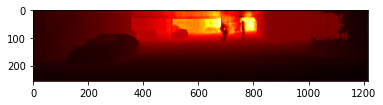

In [8]:
plt.imshow(np.squeeze(depth_predicted),cmap='hot')
plt.show()